In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import statsmodels.api as sm
from io import StringIO

import preprocessor as pp
import emoji
from nltk.tokenize import TweetTokenizer
from sklearn.neighbors import KNeighborsClassifier

import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import datetime
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /Users/ashok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
numeric_feat = np.array(['retweet_count','reply_count', 'like_count', 'quote_count', 'followers count', 
                    'following count', 'tweet count', 'listed_count'])

cat_feat = np.array(['user is verified', 'user has url'])

date_feat = np.array(['created_at', 'user created at'])

text_feat = np.array(['text', 'user description'])


class1 = 'binary_class'
class2 = 'ternary_class'

unused_feat = ['number', 'user created at', 'created_at', 'source', 'user location', class2]

cls = class1

In [3]:
def preprocess_cat(df, c):
    # one hot encoding for categorical data
    df = pd.get_dummies(df, columns = [c])
    return df

In [4]:
# TODO
def preprocess_date(df, c):
    return df

In [5]:
def filter_text(df, c):
    arr = []
    for i in range (len(df)):
        #Preprocess the tweets
        oldtext=df[c][i]
        #removes hashtags
        newtext=' '.join(re.sub("(#[A-Za-z0-9]+)"," ",str(oldtext)).split())
        #removes UserID
        newtext=' '.join(re.sub("(@[A-Za-z0-9]+)"," ",str(newtext)).split())
        #removes urls
        newtext=' '.join(re.sub("(_URL_)"," ",str(newtext)).split())
        #removes additional urls as well
        newtext=' '.join(re.sub("(\w+:\/\/\S+)"," ",str(newtext)).split())
        #keeps only alphanumeric characters
        newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext))
        #converts to lower case and splits
        newtext=newtext.lower()
        newtext=newtext.split()
        #Performs Stemming    
        ps=PorterStemmer()
        newtext= [ps.stem(word) for word in newtext if word not in set(stopwords.words('english'))]
        newtext=' '.join(newtext)
        arr.append(newtext)
    df[c] = np.array(arr)
    return df
                    
def preprocess_text(df, c):
    df = filter_text(df,c)
    corpus=[]
    for i in range(len(df)):
        newtext=df[c][i]
#         if(len(str((newtext)))!=0 and str(newtext)!='nan'):
        corpus.append(newtext)

    cv = CountVectorizer(max_features = 1000)
    X2 = cv.fit_transform(corpus).toarray()
    c_names = cv.get_feature_names_out()
    c_names = [c + '_' + x for x in c_names]
    df = df.drop(c, axis=1)
#     for i in range(len(X2[0])):
#         df[c + c_names[i]] = np.array(X2[:,i])
    
    df1 = pd.DataFrame(np.array(X2), columns=c_names)
#     print(df1.columns)
    
    df = pd.concat([df,df1], axis=1)
#     print(df.columns)
    return df

In [6]:
# TODO
def preprocess_loc(df, c):
    return df

In [7]:
def convert_to_numeric(df):
    columns = df.columns
    for c in columns:
        if c in cat_feat:
            df = preprocess_cat(df, c)
        elif c in date_feat:
            df = preprocess_date(df, c)
        elif c in text_feat:
            df = preprocess_text(df, c)
    return df

In [8]:
def normalize(df):
    for feature in df.columns:
        if feature != class1 and feature != class2:
            feature_min = df[feature].min()
            feature_max = df[feature].max()
            df[feature] = (df[feature] - feature_min) / (feature_max - feature_min)    

    return df

In [9]:
def preprocess(df):
    df = convert_to_numeric(df)
    
    df = normalize(df)
    return df

In [10]:
ds_train = pd.read_csv('../data/monkeypox.csv')
ds_test = pd.read_csv('../data/monkeypox-followup.csv')

ds_train = ds_train.drop(unused_feat, axis=1)
ds_test = ds_test.drop(unused_feat, axis=1)
ds_test = ds_test.drop('beto_flag', axis=1)
ds_train = preprocess(ds_train)
ds_test = preprocess(ds_test)

cols_to_remove = np.setdiff1d(ds_test.columns, ds_train.columns)

cols_to_add = np.setdiff1d(ds_train.columns, ds_test.columns)

ds_test = ds_test.drop(cols_to_remove, axis=1)

df1 = pd.DataFrame([[0 for i in range(len(cols_to_add))] for c in range(len(ds_test))], columns=cols_to_add)

ds_test = pd.concat([ds_test, df1], axis=1)



In [11]:
ds_train.describe

<bound method NDFrame.describe of       retweet_count  reply_count  like_count  quote_count  followers count  \
0          0.000877          0.0    0.000137     0.000000     1.670395e-04   
1          0.000877          0.0    0.000069     0.000000     3.427383e-03   
2          0.000000          0.0    0.000000     0.000000     1.288952e-04   
3          0.000438          0.0    0.000069     0.000000     1.034822e-03   
4          0.000000          0.0    0.000000     0.000000     3.674146e-03   
...             ...          ...         ...          ...              ...   
5782       0.000000          0.0    0.000000     0.000000     1.807787e-07   
5783       0.000000          0.0    0.000000     0.000000     1.807787e-07   
5784       0.000000          0.0    0.000137     0.000000     2.982848e-06   
5785       0.000000          0.0    0.000000     0.000000     1.599891e-05   
5786       0.000438          0.0    0.000275     0.000624     1.782478e-04   

      following count  tweet 

In [12]:
ds_test.describe

<bound method NDFrame.describe of      retweet_count  reply_count  like_count  quote_count  followers count  \
0         0.000000      0.00000    0.000000          0.0     1.322114e-04   
1         0.007874      0.00000    0.000000          0.0     1.174516e-07   
2         0.000000      0.00000    0.000000          0.0     1.519041e-05   
3         0.000000      0.00000    0.000000          0.0     6.350217e-05   
4         0.031496      0.00000    0.005855          0.0     8.789295e-05   
..             ...          ...         ...          ...              ...   
495       0.000000      0.00000    0.001171          0.0     2.529124e-05   
496       0.000000      0.00000    0.000000          0.0     1.418424e-04   
497       0.039370      0.01626    0.042155          0.0     1.261078e-03   
498       0.000000      0.00000    0.002342          0.0     9.004623e-06   
499       0.000000      0.00000    0.000000          0.0     3.915053e-08   

     following count  tweet count  listed

In [13]:
features = np.setdiff1d(ds_train.columns, np.array([cls]))
features

array(['followers count', 'following count', 'like_count', ...,
       'user has url_True', 'user is verified_False',
       'user is verified_True'], dtype=object)

In [14]:
ds_train_norm_cov = np.cov(ds_train[features], rowvar=False)
print(f'Size of covariance matrix: {ds_train_norm_cov.shape}')

cov_subset = []
for row in range(5):
    cov_subset.append(ds_train_norm_cov[row][:5])
print('First 5 * 5 of covariance matrix:')
print(pd.DataFrame(cov_subset))

Size of covariance matrix: (2012, 2012)
First 5 * 5 of covariance matrix:
          0             1             2         3         4
0  0.000549  8.559469e-06  9.228882e-06  0.000559  0.000004
1  0.000009  4.812368e-04  7.257887e-07  0.000019 -0.000001
2  0.000009  7.257887e-07  2.932357e-04  0.000009  0.000045
3  0.000559  1.888454e-05  8.739974e-06  0.000822  0.000007
4  0.000004 -1.216590e-06  4.548584e-05  0.000007  0.000204


In [15]:
from sklearn.decomposition import PCA

In [45]:
X = ds_train.copy()
X = X.drop(cls, axis=1)
pca = PCA(n_components=2000, random_state=0)
pca.fit(X)
X_pca = pca.transform(X)

In [46]:
print("Variance explained by all 2000 principal components =", sum(pca.explained_variance_ratio_ * 100))

Variance explained by all 2000 principal components = 99.99972607772358


In [47]:
csum = np.cumsum(pca.explained_variance_ratio_ * 100)
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 7.89406749,  9.8467856 , 11.21121756, ..., 99.99951014,
       99.9996346 , 99.99972608])

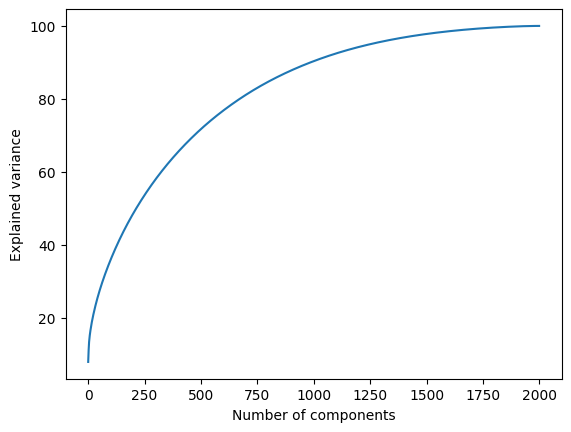

In [48]:
plt.plot(csum)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('elbow_plot.png', dpi=100)

In [61]:
csum[1326]

96.00818142732594